# Iteration 4<br/>*Categorical Encoding*

Jupyter Notebook referenced from my website: <a href="https://sdiehl28.netlify.com/projects/titanic/titanic04/" target="_blank">Software Nirvana: Categorical Encoding</a>

### Goals
1. Discuss Categorical Encoding
2. Demonstrate One Hot Encoding
3. As part of iterative model development, check if one hot encoded categorical variables improved the model's accuracy.

### Where We Are
In the third iteration, we created a model which imputed missing Age values by (pclass, sex) by writing a custom Transform class and using it as part of a pipeline.

### What's Next
Make use of non-numeric variables by encoding them as numbers.

### Categorical Encoding

Most machine learning algorithms (scikit learn estimators) require non-null numeric data to work with.  However there is much information content in non-numeric data that we would like to include in our model.  If we convert the categorical field to a number, we can use the variable in our model.

Processing text data is different from processing categorical data.  Text data is processed by the techniques of Natural Language Processing (NLP).  NLP is not discussed in this notebook.

A categorical variable takes on discrete values.  These values might be ordered, like (short, medium, tall), or unordered like (reg, green, blue).

An ordered categorical variable can reasonably be converted to an integer.  For example, (short, medium, tall) => (0, 1, 2).

An unordered categorical can be turned into a series of dummy variables, using One Hot Encoding.  By default, a categorical variable having n distinct values is converted into n (or n-1) dummy variables.

#### Encoding
There are three primary questions to ask:
1. Are the categorical values ordered?
2. Are there a large number of distinct categorical values?
3. Are all values known in advance?

No encoding is "right" or "wrong".  The "best" encoding is the one that works best for your model.  The following are only rules-of-thumb.

#### Ordered
If the categorical value has an inherent ordering, then converting the sorted values to consecutive integers is a good approach.

#### Large Number of Values
If there are a large number of distinct categorical values, then many dummy variables are created.  The more dummy variables, the higher the dimension and the more likely "the curse of dimensionality" becomes a problem.  Some estimators, such as KNN, do not work well with a high number of dimensions.

One option is to exclude a categorical variable with a large number of distinct values from the model.

Another option is to reduce the number of distinct values.  There are several ways this could be done.  If the category values form part of a hierarchy, then you could replace values with values further up in the hierarchy.  If a domain expert knows that certain category values matter and the rest are unimportant, a data transformation could be created to map all unimportant values to a single value.  If nothing is known about the data, it is reasonable to assume that rare values are less important, and to map all rare values to a single value.

#### Small Number of Values
This is where One Hot Encoding may be most useful.

#### Not All Values Known in Advance
If all the values are not known in advance, then a Scikit Learn custom transform object could be created which encodes previously unseen values to a specific value on the fly.

### Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

In [2]:
# read in all the labeled data
all_data = pd.read_csv('./data/train.csv')

# break up the dataframe into X and y
# X is a 2 dimensional "spreadsheet" of values used for prediction
# y is a 1 dimensional vector of target (aka response) values
X = all_data.drop('Survived', axis=1)
y = all_data['Survived']
print('X Shape: ', X.shape)
print('y Shape: ', y.shape)

X Shape:  (891, 11)
y Shape:  (891,)


### Exploratory Data Analysis

The fields not examined in the previous iterations are: Sex, Name, Ticket, Cabin, Embarked.

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB


### Null Value Analysis
* Cabin has too many null values to be useful, drop it
* Embarked only has 2 rows with null values, drop those rows
* Missing Age values will be handled as per previous iteration

In [4]:
# fields will be dropped later
drop_fields = ['Cabin']

# drop rows now
rows_to_keep = X['Embarked'].notnull()
X = X[rows_to_keep]
y = y[rows_to_keep]

### Categorical Fields to Encode

In [5]:
print('Number of records: ', len(X))
print('\nNumber of Unique Values')
print(f'PassengerId {X["PassengerId"].nunique()}')
print(f'Sex:        {X["Sex"].nunique()}')
print(f'Ticket:     {X["Ticket"].nunique()}')
print(f'Embarked:   {X["Embarked"].nunique()}')
print(f'Name:       {X["Name"].nunique()}')

Number of records:  889

Number of Unique Values
PassengerId 889
Sex:        2
Ticket:     680
Embarked:   3
Name:       889


With 889 records, and 889 unique values for PassengerId and Name, it is clear that PassengerId and Name are unique identifiers.  As such they offer no predictive value.

Ticket has too many unique values given that we only have 889 records.

That leaves Sex and Embarked as categorical fields that are worth encoding as dummy variables.

In [6]:
drop_fields.extend(['PassengerId','Ticket', 'Name'])
X.drop(drop_fields, axis=1, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 7 columns):
Pclass      889 non-null int64
Sex         889 non-null object
Age         712 non-null float64
SibSp       889 non-null int64
Parch       889 non-null int64
Fare        889 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 55.6+ KB


### EDA for Sex and Embarked
Compare Sex and Embarked with Survived.

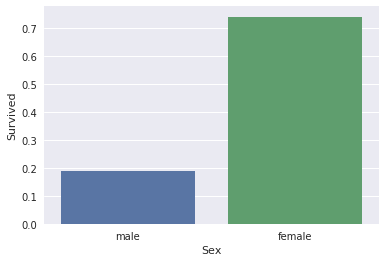

In [7]:
eda_data = X.copy()
eda_data['Survived'] = y
sns.barplot(x='Sex',y='Survived',data=eda_data, ci=None)

Sex will no doubt be an important variable for predicting survival.

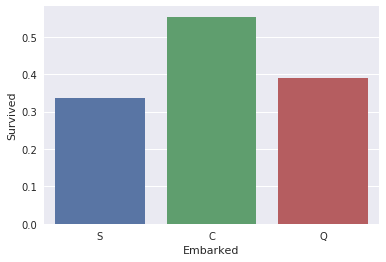

In [8]:
sns.barplot(x='Embarked',y='Survived',data=eda_data, ci=None)

The port of embark may be helpful for predicting survival.

In [9]:
# one hot encode sex
gender = pd.get_dummies(X['Sex'], prefix='gender')
gender.head(3)

gender_female  gender_male
0              0            1
1              1            0
2              1            0

Some models, such as linear regression and logistic regression, may not perform well if one variable is a near perfect linear combination of the other variables.  This is called colinearity.

gender_female and gender_male are perfectly correlated.  When one is 1 the other is 0.  One of these dummy variables should be dropped.

In [10]:
# to avoid colinearity, drop the first dummy variable
gender = pd.get_dummies(X['Sex'], prefix='gender', drop_first=True)
gender.head(3)

gender_male
0            1
1            0
2            0

In [11]:
# Same as above for embarked
port = pd.get_dummies(X['Embarked'], prefix='port',drop_first=True)
port.head(3)

port_Q  port_S
0       0       1
1       0       0
2       0       1

In [12]:
X = pd.concat([X, gender, port], axis=1)
X.head(3)

Pclass     Sex   Age  SibSp  Parch     Fare Embarked  gender_male  port_Q  \
0       3    male  22.0      1      0   7.2500        S            1       0   
1       1  female  38.0      1      0  71.2833        C            0       0   
2       3  female  26.0      0      0   7.9250        S            0       0   

   port_S  
0       1  
1       0  
2       1

Now that the categorical fields have been encoded as numbers, they can be removed from the model (as most models cannot handle categorical data directly).

However our custom transform class needs the Sex variable to impute age.  That class will remove Sex for use as the last step of the transform.

In [13]:
X.drop(['Embarked'], axis=1,inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
Pclass         889 non-null int64
Sex            889 non-null object
Age            712 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Fare           889 non-null float64
gender_male    889 non-null uint8
port_Q         889 non-null uint8
port_S         889 non-null uint8
dtypes: float64(2), int64(3), object(1), uint8(3)
memory usage: 51.2+ KB


### Model Building

In [14]:
# Custom Transform Class for Imputation
# Copied as-is from previous iteration
# Note: requires 'Sex' to be available for fit(),
# but discards 'Sex' as last step of transform()
from sklearn.base import TransformerMixin
class MyTransformer(TransformerMixin): 
    '''Class with fit() and transform() methods'''

    def fit(self, X, y):
        '''
        fit() will compute and save the mean age per (pclass, sex)
        on the training data
        '''
        self.mean_age_by_pclass_sex = X.groupby(['Pclass', 'Sex'])['Age'].mean()
        
        # return an instance of MyTransformer
        return self
    
    def transform(self, X):
        '''
        transform() is applied to both train and test data
        
        It will replace missing age values by looking up the
        mean age per (pclass,sex)
        '''
        
        # index into multi-indexed Pandas Series using 2-part key
        # Pandas does not allow indexing by DataFrame, so create list of tuples
        # each tuple is (pclass, sex)
        missing_age_idx = X['Age'].isnull()
        df = X.loc[missing_age_idx, ['Pclass', 'Sex']]
        index_tuples = list(df.itertuples(index=False, name=None))
        
        # lookup mean age in DataFrameGroupBy using list of tuples of (pclass, sex)
        imputed_age_values = self.mean_age_by_pclass_sex.loc[index_tuples].values
        
        # replace the missing values with the imputed age values
        X = X.copy()
        X.loc[missing_age_idx, 'Age'] = imputed_age_values

        # drop the sex column as logicstic regression only works with numerics
        # (later we will encode it and use it)
        return X.drop('Sex', axis=1)

In [15]:
# imports
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

k_folds = 10
random_seed=5
crossvalidation = StratifiedKFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

my_transformer = MyTransformer()

classifier = make_pipeline(my_transformer, LogisticRegression())

scores = cross_val_score(classifier, X, y, cv=crossvalidation, 
                         scoring='accuracy', n_jobs=1)

# save scores for comparison with another iteration
np.save("./data/iter04.data", scores)

print(np.round(scores,3))
print(round(np.mean(scores),3))

[0.809 0.753 0.775 0.854 0.854 0.798 0.775 0.787 0.798 0.795]
0.8


### Compare Model with Previous Iteration

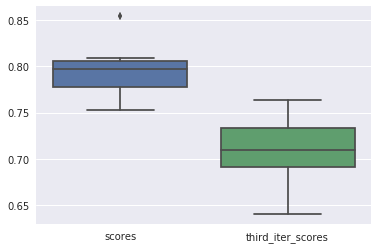

In [16]:
# Read in scores from 3rd iteration
third_iter_scores = np.load('./data/iter03.data.npy')

df = pd.DataFrame(data=list(zip(scores, third_iter_scores)),
                  columns=['scores','third_iter_scores'])
sns.boxplot(data=df)
plt.savefig(fname='4_vs_3.png', dpi=120)

In [17]:
# the scores in the ordered list correspond with each other as they were
# perform on the same train/test split
diff_scores = scores - third_iter_scores
print(np.round(sorted(diff_scores),3))

[0.034 0.042 0.057 0.067 0.079 0.09  0.112 0.12  0.146 0.157]


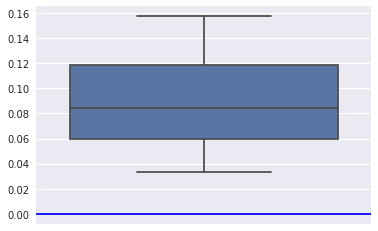

In [18]:
# boxplot the differences and highlight x-axis
sns.boxplot(y=diff_scores)
plt.axhline(0, color='blue')

In [19]:
# How many times is the new model better?
print(f'New Model wins:  {(diff_scores > 0).sum()}')
print(f'New Model ties:  {(diff_scores == 0).sum()}')
print(f'New Model loses: {(diff_scores < 0).sum()}')

New Model wins:  10
New Model ties:  0
New Model loses: 0


The above shows that the new model is very much better.  Sex and Embarked provided information that the LogisticRegression model could use to make better predictions.

### Model Summary
Model Building Steps Only

In [20]:
# read in all the labeled data
all_data = pd.read_csv('./data/train.csv')

# break up the dataframe into X and y
X = all_data.drop('Survived', axis=1)
y = all_data['Survived']

# drop string columns with too many values or too many nulls
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
X = X.drop(drop_cols, axis=1)

# drop rows with Embarked null
rows_to_keep = X['Embarked'].notnull()
X = X[rows_to_keep]
y = y[rows_to_keep]

# one-hot encode Sex and Embarked
gender = pd.get_dummies(X['Sex'], drop_first=True, prefix='gender')
port = pd.get_dummies(X['Embarked'], drop_first=True, prefix='port')
X = pd.concat([X, gender, port], axis=1)

# remove it as it was one-hot encoded
# but keep 'Sex' as it is needed by the custom transform
X.drop(['Embarked'], axis=1, inplace=True)

k_folds = 10
random_seed=5
crossvalidation = StratifiedKFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

my_transformer = MyTransformer()

classifier = make_pipeline(my_transformer, LogisticRegression())

scores = cross_val_score(classifier, X, y, cv=crossvalidation, 
                         scoring='accuracy', n_jobs=1)

# save scores for comparison with another iteration
np.save("./data/iter04.data", scores)

print(np.round(scores,3))
print(round(np.mean(scores),3))

[0.809 0.753 0.775 0.854 0.854 0.798 0.775 0.787 0.798 0.795]
0.8


In [21]:
# previous model
print(f'Previous Cross Validated Accuracy: {third_iter_scores.mean() :.3f}')

Previous Cross Validated Accuracy: 0.709


### Notebook Summary

The LogisticRegression model was able to make use of information represented in the Sex and Embarked variables, when these variables were encoded as numbers using one-hot enocoding, and included in the model.

In this iteration we:
* Demonstrated one hot encoding for Sex and Embarked
* Measured the new model's accuracy and found it was much better (80.0% vs 70.9%).